### Optimal Design for Conformer Search

Conformers are particular types of isomers created by changing the dihedral angle between a single bond within a molecule. Within the conformational space, conformers represent the local minima of such isomers when plotted on a potential energy graph as a function of dihedral angle. Finding lower-energy conformers are important because they represent the stable versions of a molecule in their conformational space and can be used in many practical applications as well as further our understanding of chemical reactions and atomic interactions within a molecule. 

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from confutils import get_dihedral_info, get_initial_structure, set_dihedrals_and_relax, relax_structure
from tqdm import tqdm
import pickle as pkl
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')

##### Active Learning for n-butane

Using active learning to optimize n-butane with two dihedral angles of interest,  $\phi_1$ and $\phi_2$. 


In [3]:
## Loading conformer data of n-butane 

butane = pd.read_csv('data/n-butane.csv')

## generating subset of butane energies where phi2 is constant 
butane_subset = butane[:33]

##### Learning a Potential Energy Surface
Representing a function that predicts a molecule's energy as a function of dihedral angles: $K(x, y) = \sum_i \exp(-2 \frac{\sin^2(\pi (x_i - y_i)^2/p)}{l^2})$

In [4]:
def elementwise_expsine_kernel(x, y, gamma=10, p=360):
    """Compute the exponential sine kernel
    
    Args:
        x, y: Coordinates to be compared
        gamma: Length scale of the kernel
        p: Periodicity of the kernel
    Returns:
        Kernel metric
    """
    
    # Compute the distances between the two points
    dists = np.subtract(x, y)
    
    # Compute the sine with a periodicity of p
    sine_dists = np.sin(np.pi * dists / p)
    
    # Return exponential of the squared kernel
    return np.sum(np.exp(-2 * np.power(sine_dists, 2) / gamma ** 2), axis=-1)

from sklearn.gaussian_process import GaussianProcessRegressor, kernels

Creating two models: one with the periodic sine kernel function above and another with a RBF kernel

In [5]:
sine_kernel = GaussianProcessRegressor(
    kernel=kernels.PairwiseKernel(metric=elementwise_expsine_kernel),
    # Starts using different guesses for parameters to achieve better fitting
    n_restarts_optimizer=4  
)

from sklearn.gaussian_process.kernels import RBF

rbf_kernel = GaussianProcessRegressor(
    kernel=RBF(),
    n_restarts_optimizer=16
)

## sampling two points from the butane subset
butane_samples = butane_subset.sample(2)

In [6]:
## fitting model with the two butane samples
sine_kernel.fit(np.vstack(butane_samples['phi1']), np.vstack(butane_samples['energy']))
rbf_kernel.fit(np.vstack(butane_samples['phi1']), np.vstack(butane_samples['energy']))

GaussianProcessRegressor(kernel=RBF(length_scale=1), n_restarts_optimizer=16)

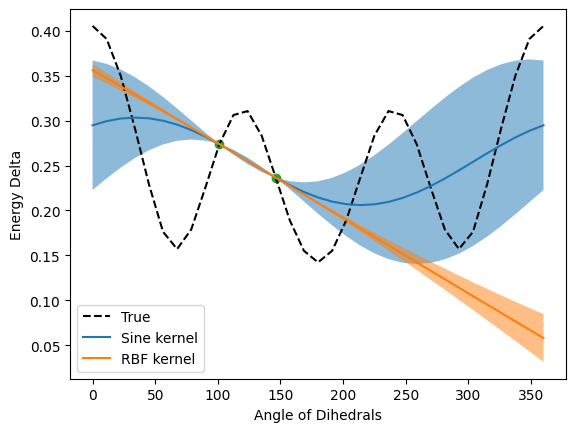

In [7]:
fig, ax = plt.subplots()

## plotting real data points from the butane dataset
ax.plot(butane_subset['phi1'], butane_subset['energy'], 'k--', label='True')

## plotting fitted gaussian function with the periodic sine kernel
y_pred_sin, y_std_sin = sine_kernel.predict(np.vstack(butane_subset['phi1']), return_std=True)
ax.plot(butane_subset['phi1'], sine_kernel.predict(np.vstack(butane_subset['phi1'])), label='Sine kernel')
ax.fill_between(butane_subset['phi1'], y_pred_sin - y_std_sin, y_pred_sin + y_std_sin, alpha=0.5)

## plotting fitted gaussian function with the rbf kernel
y_pred_rbf, y_std_rbf = rbf_kernel.predict(np.vstack(butane_subset['phi1']), return_std=True)
ax.plot(butane_subset['phi1'], y_pred_rbf, label='RBF kernel')
ax.fill_between(butane_subset['phi1'], y_pred_rbf - y_std_rbf, y_pred_rbf + y_std_rbf, alpha=0.5)

## plotting two training points 
ax.scatter(np.vstack(butane_samples['phi1']), np.vstack(butane_samples['energy']))

ax.set_xlabel('Angle of Dihedrals')
ax.set_ylabel('Energy Delta')
ax.legend()

Using entire butane dataset and training each model with randomly-selected subsets of 3, 10, 30, and 100 points: 

In [ ]:
train_size = [3, 10, 30, 100] ## sine kernel
results_sin = []

from sklearn.metrics import mean_absolute_error

for ts in tqdm(train_size): 
    butane_data = butane.sample(ts)
    sine_kernel.fit(np.vstack(butane_data['phi1']), np.vstack(butane_data['energy']))
    y_pred = sine_kernel.predict(np.vstack(butane['phi1']))
    
    results_sin.append({
        'train_size': ts, 
        'mae': mean_absolute_error(y_pred, butane['energy'])
    })

results_rbf = []

for ts in tqdm(train_size): 
    butane_data = butane.sample(ts)
    rbf_kernel.fit(np.vstack(butane_data['phi1']), np.vstack(butane_data['energy']))
    y_pred = rbf_kernel.predict(np.vstack(butane['phi1']))
    
    results_rbf.append({
        'train_size': ts, 
        'mae': mean_absolute_error(y_pred, butane['energy'])
    })


 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00,  4.51it/s]

In [ ]:
results_sin = pd.DataFrame(results_sin)
results_rbf = pd.DataFrame(results_rbf)

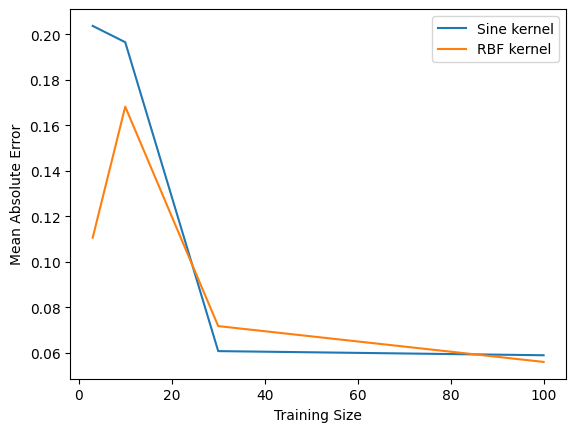

In [38]:
fig, ax = plt.subplots() ## plotting error as a function of training size

ax.plot(results_sin['train_size'], results_sin['mae'], label='Sine kernel')
ax.plot(results_rbf['train_size'], results_rbf['mae'], label='RBF kernel')

ax.set_xlabel('Training Size')
ax.set_ylabel('Mean Absolute Error')
ax.legend()

The Sine kernel model performs better than the RBF kernel with fewer training datapoints because it is able to capture the periodicity of n-butane's conformational space in relation to its molecular energy, while the RBF kernel is effective for non-linear decision boundaries in general, yet it does not reflect the specific periodicity patterns associated with the n-butane dataset as well as the sine kernel. 

##### Using Bayesian Optimization to guide search for conformers: 

In [11]:
butane_sample = butane.sample(4) # selecting four points at random

In [12]:
from modAL.models import BayesianOptimizer
from modAL.acquisition import max_EI
from modAL.disagreement import max_std_sampling

In [13]:
EI_optimizer = BayesianOptimizer( # defining a bayesian optimizer with a surrogate model, initial training pool, and an acquisition function
    estimator = sine_kernel, 
    X_training = butane_sample[['phi1', 'phi2']].values, 
    y_training = -butane_sample['energy'].values, # negating y_training to make this optimizer a minimization problem (typically, optimizers are maximization problems and expect values that are already maximized. by setting y_training negative, it will try to find lower values, aligning with our goals!)
    query_strategy = max_EI
)

In [14]:
num_steps = 16 # identifying 16 other points using expected improvement

train_X = np.array(butane[['phi1', 'phi2']].values) # converting training sets into numpy arrays
train_y = np.array(butane['energy'].values)

results_EI = []

for steps in tqdm(range(num_steps)): 
    # using the acquisition function to identify most 'interesting' points to use next
    indices, instances = EI_optimizer.query(train_X)   
    # labelling (assigning a value) to the queried points
    EI_optimizer.teach(train_X[indices], -train_y[indices])
    # removing query from the unlabelled pool
    train_X = np.delete(train_X, indices, axis=0)    
    # identifying lowest-energy conformer
    lowest_value = np.min(-train_y[indices])
    # saving results 
    results_EI.append({
        'number of steps': steps, 
        'minimum energy value': lowest_value
    })
    

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:14<00:00,  1.08it/s]


In [15]:
SD_optimizer = BayesianOptimizer(
    estimator = sine_kernel, 
    X_training = butane_sample[['phi1', 'phi2']].values, 
    y_training = -butane_sample['energy'].values, 
    query_strategy = max_std_sampling
)

In [16]:
num_points = 16 # identifying 16 other points using uncertainty sampling (finding point with highest uncertainty)

train_X = np.array(butane[['phi1', 'phi2']].values) # converting training sets into numpy arrays
train_y = np.array(butane['energy'].values)

results_SD = []

for steps in tqdm(range(num_points)):
    # using the acquisition function to identify most 'interesting' points to use next
    indices, instances = SD_optimizer.query(train_X)   
    # labelling (assigning a value) to the queried points
    SD_optimizer.teach(train_X[indices], -train_y[indices])
    # removing query from the unlabelled pool
    train_X = np.delete(train_X, indices, axis=0)  
    # identifying lowest-energy conformer
    lowest_value = np.min(-train_y[indices])
    # saving results 
    results_SD.append({
        'number of steps': steps, 
        'minimum energy value': lowest_value, 
    })

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.19it/s]


Plotting the lowest-energy conformer as a function of step for each strategy: 

In [17]:
results_EI = pd.DataFrame(results_EI)
results_SD = pd.DataFrame(results_SD)

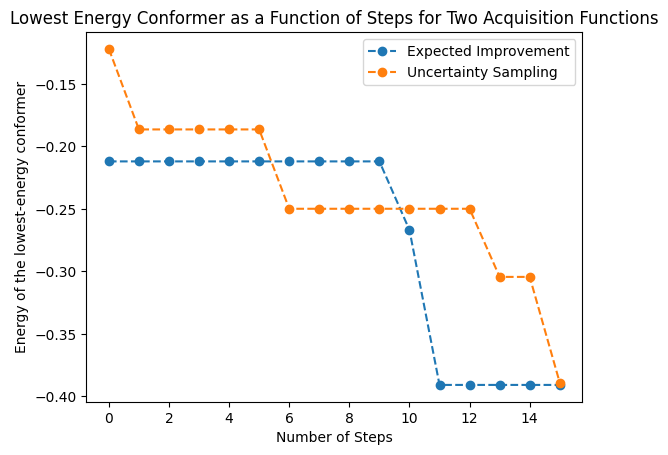

In [18]:
fig, ax = plt.subplots()
ax.plot(results_EI['number of steps'], np.minimum.accumulate(results_EI)['minimum energy value'], '--o', label='Expected Improvement')
ax.plot(results_SD['number of steps'], np.minimum.accumulate(results_SD)['minimum energy value'], '--o', label='Uncertainty Sampling')
ax.set_xlabel('Number of Steps')
ax.set_ylabel('Energy of the lowest-energy conformer')
ax.set_title('Lowest Energy Conformer as a Function of Steps for Two Acquisition Functions')
ax.legend()

Measuring the prediction performance of each model on the full dataset over multiple iterations: 

In [25]:
results_ei = []

for i in range(10): 
    butane_samples = butane.sample(4)
    EI_optimizer.fit(butane_samples[['phi1', 'phi2']], butane_samples['energy'])
    y_pred_EI = EI_optimizer.predict(butane[['phi1', 'phi2']])
    results_ei.append({
        'iterations': i, 
        'mae': mean_absolute_error(y_pred_EI, butane['energy'])
    })

In [26]:
results_sd = []

for i in range(10): 
    butane_samples = butane.sample(4)
    SD_optimizer.fit(butane_samples[['phi1', 'phi2']], butane_samples['energy'])
    y_pred_SD = SD_optimizer.predict(butane[['phi1', 'phi2']])
    mean_absolute_error(y_pred_SD, butane['energy'])
    results_sd.append({
        'iterations': i, 
        'mae': mean_absolute_error(y_pred_SD, butane['energy'])
    })

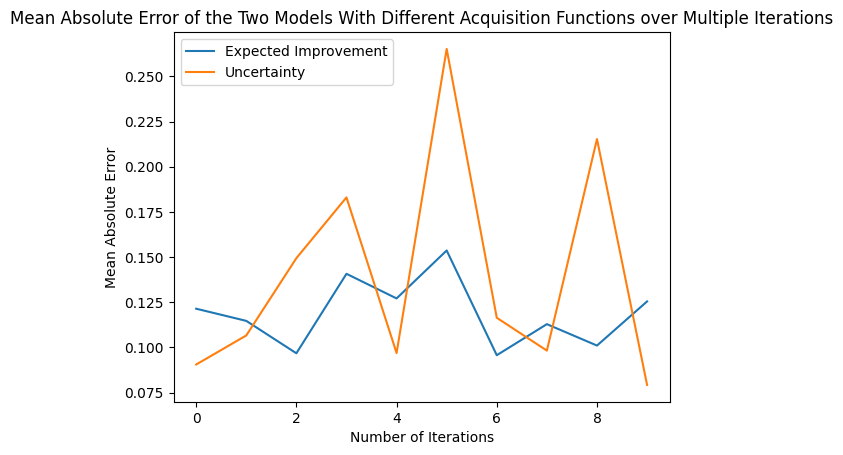

In [27]:
results_ei = pd.DataFrame(results_ei)
results_sd = pd.DataFrame(results_sd)

fig, ax = plt.subplots()
ax.plot(results_ei['iterations'], results_ei['mae'], label='Expected Improvement')
ax.plot(results_sd['iterations'], results_sd['mae'], label='Uncertainty')

ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Mean Absolute Error')
ax.set_title('Mean Absolute Error of the Two Models With Different Acquisition Functions over Multiple Iterations')

ax.legend()

Although the mean absolute error will fluctuate between runs, the majority of them have shown expected improvement as the acquisition function that is able to find the lowest conformer and possess more accurate model performance. Expected improvement takes into the probability of a prediction being greater (or less than, in this case) a previous prediction, the model's variance, and the difference between the model's mean value and the best current value. Because higher values are assigned to both higher mean values and uncertainty, expected improvement is able to obtain maximum values and lower error with fewer runs compared to uncertainty sampling. 

#### Optimizing cysteine using global optimization

Unlike butane, cysteine has five adjustable bonds; as a result, many more datapoints would be required to effectively sample the conformer space, increasing computational times significantly. 

In [28]:
# Molecular structure of cysteine
with open('data/cysteine-atoms.pkl', 'rb') as fp:
    cysteine = pkl.load(fp)

# Definitions for the dihedral angles of cysteine
with open('data/dihedrals.pkl', 'rb') as fp:
    dihedrals = pkl.load(fp)

Defining a function that will compute the energy of a cysteine molecule given its five dihedral angles: 

In [29]:
def evaluate_energy(angles):
    """Compute the energy of a cysteine molecule given dihedral angles
    
    Args:
        angles: List of dihedral angles
    Returns:
        energy of the structure
    """
    c_atoms, c_bonds = get_initial_structure('C([C@@H](C(=O)O)N)S') # generating initial geometry of cysteine
    cysteine = c_atoms
    
    backbone = [0, 1, 2, 3, 5, 6] # using indices of the backbone molecules of cysteine
    
    d1 = get_dihedral_info(c_bonds, [1, 2], backbone_atoms=backbone) # define each interested dihedral 
    d2 = get_dihedral_info(c_bonds, [0, 1], backbone_atoms=backbone)
    d3 = get_dihedral_info(c_bonds, [1, 5], backbone_atoms=backbone)
    d4 = get_dihedral_info(c_bonds, [2, 4], backbone_atoms=backbone)
    d5 = get_dihedral_info(c_bonds, [0, 6], backbone_atoms=backbone)
    dihedrals = [d1, d2, d3, d4, d5]
    
    return set_dihedrals_and_relax(
        cysteine,
        zip(angles, dihedrals)
    )

##### Defining another function to identify all samples used during the optimization process through the use of a multi-start local optimizer and scipy's minimize function: 

A multi-start local optimizer utilizes many initial points at different starting positions in order to identify the global maxima of a particular function. These initial points are optimized independently of each other through various methods such as gradient-descent or other derivative-free methods (do not require objective knowledge of the function). All optimized solutions are compared with each other to determine the global maxima (or minima) of the entire function with high confidence. 

In this function, the Nelder-Mead method is used, which creates a simplex (triangle-like figure) of n+1 points in the n-dimensional space. It aims to find another point that represents the unknown function better than the previous one by reflecting the current best function value over the centroid of the remaining n-points. If the newly-reflected point has a higher function value, the simplex will expand in the direction of improvement. If the newly-reflected point has a lower function value than the best, but is still better than the worst point, the simplex contracts, continuing to search the region around the best point. Finally, if the newly-reflected is the worst function value discovered thus far, the simplex will shrink, restricting the search towards a region of improvement. 

In [30]:
from scipy.optimize import minimize
import numpy as np

def get_search_space(optimizer: BayesianOptimizer, n_samples: int = 32):
    """Generate many samples by attempting to find the minima using a multi-start local optimizer
    
    Args: 
        optimizer: Optimizer being used to perform Bayesian optimization
        n_samples: Number of initial starts of the optimizer to use. 
            Will return all points sampled by the optimizer
    Returns:
        List of points to be considered
    """
    
    # Generate random starting points
    init_points = np.random.uniform(0, 360, size=(n_samples, 5))
    
    # Use local optimization to find the minima near these
    points_sampled = []  # Will hold all samples tested by the optimizer
    for init_point in init_points:
        minimize(
            # Define the function to be optimized
            #  The optimizer requires a 2D input and returns the negative energy
            #  We make our inputs 2D and compute the negative energy with a lambda function
            lambda x: -optimizer.predict([x]),  # Model predicts the negative energy and requires a 2D array,
            init_point,  # Initial guess
            method='nelder-mead',  # A derivative-free optimizer
             # Stores the points sampled by the optimizer at each step in "points_sampled"
            callback=points_sampled.append
        )
    
    # Combine the results from the optimizer with the initial points sampled
    all_points = np.vstack([
        init_points,
        *points_sampled
    ])
    return all_points

#### Building a global optimization algorithm!

In [31]:
num_points = 4 

initial_data = [] # creating 4 initial points w/ random dihedral angles and computing their energies

for x in range(num_points): 
    phis = np.random.uniform(0, 360, 5)
    y = evaluate_energy(phis)
    initial_data.append({
        'dh1': phis[0], 
        'dh2': phis[1], 
        'dh3': phis[2], 
        'dh4': phis[3], 
        'dh5': phis[4],
        'energy': y
    })

initial_data = pd.DataFrame(initial_data)

In [32]:
EI_optimizer_global = BayesianOptimizer( # defining a bayesian optimizer with a surrogate model, initial training pool, and an acquisition function
    estimator = sine_kernel, 
    X_training = initial_data[['dh1', 'dh2', 'dh3', 'dh4', 'dh5']].values, 
    y_training = -initial_data['energy'].values, # negating y_training to make this optimizer a minimization problem (typically, optimizers are maximization problems and expect values that are already maximized. by setting y_training negative, it will try to find lower values, aligning with our goals!)
    query_strategy = max_EI
)

Defining a training loop to implement the global optimization algorithm: 

In [33]:
num_iterations = 32 

results = []

for i in tqdm(range(num_iterations)): 
    all_points = get_search_space(EI_optimizer_global, n_samples=32) # creating a series of 32 points to sampled
    indices, instances = EI_optimizer_global.query(all_points) # using the optimizer to determine best points to investigate
    energies = evaluate_energy(all_points[indices].ravel()) # calculating the energy of the chosen points
    EI_optimizer_global.teach(all_points[indices], np.expand_dims(energies, 0)) # inserting new points into the traiing set
    all_points = np.delete(all_points, indices)
    # saving the results 
    results.append({
        'number_of_steps': i, 
        'energy': energies
    })

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [04:46<00:00,  8.96s/it]


In [34]:
results = pd.DataFrame(results)

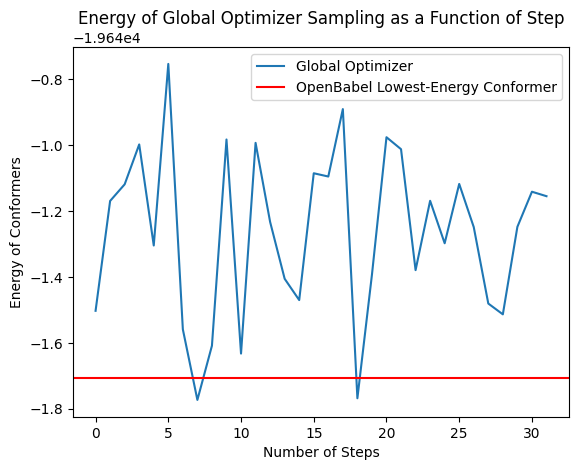

In [35]:
fig, ax = plt.subplots()
ax.plot(results['number_of_steps'], results['energy'], label='Global Optimizer')
ax.axhline(y=-19641.7084, color='r', label='OpenBabel Lowest-Energy Conformer')
ax.set_xlabel('Number of Steps')
ax.set_ylabel('Energy of Conformers')
ax.set_title('Energy of Global Optimizer Sampling as a Function of Step')

ax.legend()

Using global optimization, the model is able to find conformers with lower-energies than models reliant on OpenBabel (its average is shown through the red line on the graph)!